<a href="https://colab.research.google.com/github/bmalecki/animal-shelter-kaggle/blob/master/animal_shelter_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float64')


In [129]:
data_df = pd.read_csv("drive/My Drive/animal-shelter/train.csv")
data_df

,ID,Animal ID,Name,DateTime,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,95779,A720945,Jeet,02/19/2016 07:11:00 PM,12/03/2015,Adoption,Dog,Intact Male,2 months,Rottweiler Mix,Tricolor
1,97632,A697146,NaN,02/19/2015 09:00:00 AM,06/18/2014,Transfer,Cat,Unknown,8 months,Domestic Shorthair Mix,Black/White
2,117838,A818712,Diamond,06/14/2020 11:34:00 AM,06/13/2019,Return to Owner,Dog,Intact Female,1 year,Siberian Husky,Red/White
3,10803,A673623,Shtinker,03/09/2014 12:13:00 PM,02/27/2011,Return to Owner,Dog,Spayed Female,3 years,Chihuahua Shorthair Mix,White/Brown
4,100331,A742185,NaN,01/18/2017 08:15:00 AM,01/17/2015,Euthanasia,Other,Unknown,2 years,Coyote,Brown
...,...,...,...,...,...,...,...,...,...,...,...
96325,50057,A753764,Princess,07/11/2017 01:19:00 PM,07/10/2015,Return to Owner,Dog,Intact Female,2 years,Pomeranian Mix,White/Brown
96326,98047,A714597,Crazy,02/02/2016 12:58:00 PM,09/25/2015,Adoption,Cat,Spayed Female,4 months,Domestic Shorthair Mix,Blue/White
96327,5192,A696264,Chocolate,02/08/2015 05:26:00 PM,02/01/2013,Euthanasia,Dog,Neutered Male,2 years,Pit Bull Mix,Chocolate/White
96328,77708,A670869,Gregory,01/19/2014 03:01:00 PM,10/31/2013,Transfer,Dog,Neutered Male,2 months,Pit Bull/Labrador Retriever,Black/White


In [130]:
out_columns = data_df['Outcome Type'].unique()
out_columns.sort()
out_columns

array(['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Missing',
       'Relocate', 'Return to Owner', 'Rto-Adopt', 'Transfer'],
      dtype=object)

In [131]:
def mapAge(row):
  s = str(row['Age upon Outcome']).split()
  if pd.isna(row['Age upon Outcome']):
    s = '8 year'

  days = 2920; # 8 year

  if s[1].startswith("year"):
    days = int(s[0]) * 365
  if s[1].startswith("month"):
    days = int(s[0]) * 30
  if s[1].startswith("week"):
    days = int(s[0]) * 7
  if s[1].startswith("day"):
    days = int(s[0])
  
  if days < 0:
    days *= -1

  return days / (30*365) # normalize

def prepare_data(df):
  df['hasName'] = df.apply(lambda row : int(pd.notnull(row['Name'])), axis = 1)
  df['ageInDays'] = df.apply(mapAge, axis = 1)
  df['quarter'] = (pd.DatetimeIndex(df['DateTime']).month /4).astype(int)

  df['Male'] = df.apply(lambda row : int('Male' in str(row['Sex upon Outcome'])), axis = 1)
  df['Female'] = df.apply(lambda row : int('Female' in str(row['Sex upon Outcome'])), axis = 1)
  df['Spayed'] = df.apply(lambda row : int('Spayed' in str(row['Sex upon Outcome'])), axis = 1)
  df['Neutered'] = df.apply(lambda row : int('Neutered' in str(row['Sex upon Outcome'])), axis = 1)
  df['Intact'] = df.apply(lambda row : int('Intact' in str(row['Sex upon Outcome'])), axis = 1)
  df['Unknow'] = df.apply(lambda row : int('Unknow' in str(row['Sex upon Outcome'])), axis = 1)


  df['Tricolor'] = df.apply(lambda row : int('Tricolor' in str(row['Color'])), axis = 1)
  df['DarkFur'] = df.apply(lambda row : int(('Gray' or 'Black' or 'Brown' or 'Blue') in str(row['Color'])), axis = 1)
  df['MixBreed'] = df.apply(lambda row : int('Mix' in str(row['Breed']) or '/' in str(row['Breed'])), axis = 1)

  df = pd.get_dummies(df, prefix='', prefix_sep='_', columns=['Animal Type'])
  df = pd.get_dummies(df, prefix='quarter', columns=['quarter'])

  df = df.drop(['Animal ID', 'Name', 'Age upon Outcome', 'DateTime',
                'Date of Birth', 'Breed', 'Sex upon Outcome', 'Color'],
               axis=1)

  return df

# df = prepare_data(data_df.sample(n=1000))
# df = prepare_data(data_df.copy(deep=True).head(20000))
df = prepare_data(data_df)
df

,ID,Outcome Type,hasName,ageInDays,Male,Female,Spayed,Neutered,Intact,Unknow,Tricolor,DarkFur,MixBreed,_Bird,_Cat,_Dog,_Livestock,_Other,quarter_0,quarter_1,quarter_2,quarter_3
0,95779,Adoption,1,0.005479,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0
1,97632,Transfer,0,0.021918,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
2,117838,Return to Owner,1,0.033333,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,10803,Return to Owner,1,0.100000,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
4,100331,Euthanasia,0,0.066667,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96325,50057,Return to Owner,1,0.066667,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
96326,98047,Adoption,1,0.010959,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
96327,5192,Euthanasia,1,0.066667,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
96328,77708,Transfer,1,0.005479,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [132]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils

shelter_features = df.columns.to_list()
shelter_features.remove('Outcome Type')

# Separate features and labels
shelter_X, shelter_y = df[shelter_features], (df['Outcome Type'].rank(method='dense', ascending=True).astype(int) - 1)



# Split data 70%-30% into training set and test set
x_shelter_train, x_shelter_test, y_shelter_train, y_shelter_test = train_test_split(shelter_X, shelter_y,
                                                                                    test_size=0.30,
                                                                                    random_state=3,
                                                                                    stratify=shelter_y)
shelter_features.remove('ID')


train_ids = x_shelter_train.pop('ID')
test_ids = x_shelter_test.pop('ID').values

print ('Training Set: %d, Test Set: %d \n' % (x_shelter_train.size, x_shelter_test.size))

y_shelter_train = utils.to_categorical(y_shelter_train)
y_shelter_test = utils.to_categorical(y_shelter_test)

Training Set: 1348620, Test Set: 577980 



In [133]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

tf.random.set_seed(0)

# Define a classifier network

model = Sequential()
model.add(Dense(50, input_dim=len(shelter_features), activation='relu'))
model.add(Dense(30, input_dim=50, activation='relu'))
# model.add(Dense(10, input_dim=20, activation='relu'))
model.add(Dense(len(out_columns), input_dim=30, activation='softmax'))

print(model.summary())


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_31 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_32 (Dense)             (None, 9)                 279       
Total params: 2,859
Trainable params: 2,859
Non-trainable params: 0
_________________________________________________________________
None


In [134]:
#hyper-parameters for optimizer
learning_rate = 0.001
opt = optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

num_epochs = 10
history = model.fit(x_shelter_train, y_shelter_train, epochs=num_epochs, batch_size=10, validation_data=(x_shelter_test, y_shelter_test))


Epoch 1/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.9060 - accuracy: 0.6634 - val_loss: 0.8753 - val_accuracy: 0.6706
Epoch 2/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8613 - accuracy: 0.6757 - val_loss: 0.8501 - val_accuracy: 0.6737
Epoch 3/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8470 - accuracy: 0.6788 - val_loss: 0.8438 - val_accuracy: 0.6796
Epoch 4/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8397 - accuracy: 0.6808 - val_loss: 0.8458 - val_accuracy: 0.6751
Epoch 5/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8366 - accuracy: 0.6814 - val_loss: 0.8402 - val_accuracy: 0.6815
Epoch 6/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8335 - accuracy: 0.6826 - val_loss: 0.8500 - val_accuracy: 0.6777
Epoch 7/10
6744/6744 [==============================] - 10s 1ms/step - loss: 0.8324 - accuracy: 0.6819 - val_loss: 0.8363 - val_ac

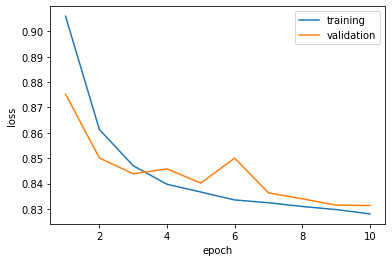

In [135]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [136]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn. metrics import classification_report

%matplotlib inline

shelter_prediction = model.predict(x_shelter_test)
predictions = np.argmax(shelter_prediction, axis=1)
true_labels = np.argmax(y_shelter_test, axis=1)

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78     12722
           1       0.00      0.00      0.00       270
           2       0.20      0.01      0.02       126
           3       0.80      0.54      0.65      1940
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00         5
           6       0.54      0.38      0.44      5056
           7       0.00      0.00      0.00       150
           8       0.76      0.60      0.67      8614

    accuracy                           0.68     28899
   macro avg       0.33      0.27      0.28     28899
weighted avg       0.67      0.68      0.66     28899



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


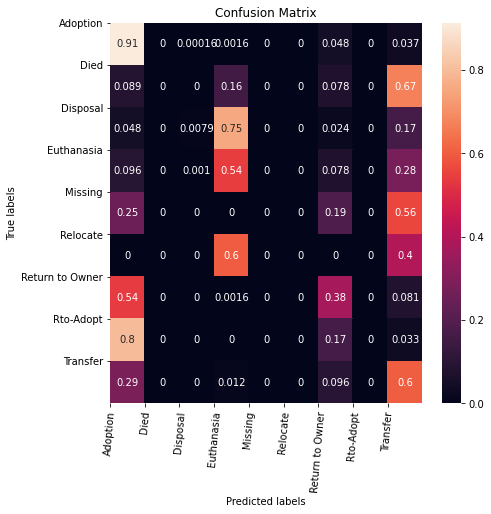

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt    
 

cm = confusion_matrix(true_labels, predictions)
cm = cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(7, 7))

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

tick_marks = np.arange(len(out_columns))
plt.xticks(tick_marks, out_columns, rotation=85)
plt.yticks(tick_marks, out_columns, rotation=0)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(out_columns); ax.yaxis.set_ticklabels(out_columns);


In [158]:
# %%script false --no-raise-error
from datetime import datetime

timestamp = datetime.timestamp(datetime.now())
isodate = datetime.fromtimestamp(timestamp).isoformat()

dftest_orginal = pd.read_csv("drive/My Drive/animal-shelter/test.csv")
dftest = prepare_data(dftest_orginal)

dftest_ids = dftest.pop("ID")
shelter_prediction_td = model.predict(dftest).round(2)

out_df = pd.DataFrame(shelter_prediction_td, columns=out_columns)
out_df.insert(0, 'ID', dftest_ids)

out_df.to_csv(f'drive/My Drive/animal-shelter/result/{isodate}_full-result.csv', index=False)

out_df

,ID,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,56924,0.37,0.00,0.00,0.05,0.00,0.00,0.44,0.02,0.13
1,56562,0.01,0.04,0.01,0.04,0.00,0.00,0.00,0.00,0.90
2,54616,0.65,0.00,0.00,0.01,0.00,0.00,0.19,0.01,0.13
3,11445,0.50,0.00,0.00,0.02,0.00,0.00,0.33,0.02,0.13
4,85086,0.55,0.00,0.00,0.02,0.00,0.00,0.26,0.01,0.15
...,...,...,...,...,...,...,...,...,...,...
24078,40702,0.33,0.05,0.00,0.03,0.01,0.00,0.05,0.00,0.53
24079,98167,0.60,0.00,0.00,0.02,0.00,0.00,0.21,0.01,0.16
24080,19858,0.01,0.04,0.16,0.73,0.00,0.01,0.00,0.00,0.06
24081,3829,0.52,0.00,0.00,0.02,0.00,0.00,0.33,0.02,0.12
